In [182]:
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.auto import tqdm

In [2]:
stai_scores = pd.read_csv(f'./data_2023/stai_scores.csv', header=None, names=['stai'])

# Task (a)

In [3]:
stai_mean = stai_scores.mean()

stai_std = stai_scores.std()

stai_median = stai_scores.median()

In [4]:
f"stai mean: {float(stai_mean)}"

'stai mean: 42.72'

In [5]:
f"stai std: {float(stai_std)}"

'stai std: 14.880531041654146'

In [6]:
f"stai median: {float(stai_median)}"

'stai median: 40.0'

In [7]:
cutoff = 43

illnes = stai_scores[stai_scores.stai >= cutoff]

illnes

,stai
0,65
1,46
2,61
4,51
5,48
6,65
7,47
8,63
9,57
10,73


In [8]:
list(illnes.index)

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23]

In [9]:
[i for i in range(26) if i not in list(illnes.index)]

[3, 15, 24, 25]

In [10]:
inst_choices = pd.read_csv(f'./data_2023/inst_choices.csv', header=None)

In [11]:
choice_count = inst_choices.apply(lambda x: x.value_counts(), axis=1)

A_count = choice_count[1]
B_count = choice_count[2]

In [12]:
A_count.mean()

34.46

In [13]:
choice_count.iloc[2]

2    128
1     32
Name: 2, dtype: int64

# Task (b)

In [224]:
def get_V(v_t, a, o):
    return v_t + a * (o - v_t)

In [225]:
def get_p(v_a, v_b, b):
    return np.exp((-b) * v_a) / ((np.exp((-b) * v_a)) + (np.exp((-b) * v_b)))

In [226]:
def change_state(last_state):
    if last_state == (0.7, 0.3):
        return (0.8, 0.2)
    elif last_state == (0.8, 0.2):
        return (0.6, 0.4)
    elif last_state == (0.6, 0.4):
        return (0.65, 0.35)
    elif last_state == (0.65, 0.35):
        return (0.7, 0.3)
    else:
        raise ValueError(f'Unexpected {last_state}')

In [227]:
alpha = 0.4
beta = 7

In [228]:
def generate_stimuli(alpha, beta):
    state = (0.7, 0.3)

    num = 160

    sim_choice = np.zeros(num)
    sim_outcome = np.zeros(num)

    V_A = 0.5
    V_B = 0.5

    for t in range(num):
        if (t + 1) % 40 == 0:
            state = change_state(state)

        p_A = get_p(V_A, V_B, beta)

        choice = 1 if np.random.rand() < p_A else 2

        check = np.random.rand()
        thres = state[0]

        outcome = int(check < thres) if choice == 1 else int(check > thres)

    #     print(f"c: {'A' if choice == 1 else 'B'}, o: {'-' if outcome == 0 else 'aversive'}")

        sim_choice[t] = choice
        sim_outcome[t] = outcome

        V_A = get_V(V_A, alpha, outcome) if choice == 1 else V_A
        V_B = get_V(V_B, alpha, outcome) if choice == 2 else V_B
    
    return sim_outcome

In [19]:
avg_aversive = 0

for i in range(0, 1000):
    avg_aversive = (avg_aversive + generate_stimuli(alpha, beta)[0: 160].sum()) / 2
    
avg_aversive

57.34290564701987

# Task (c)

In [20]:
inst_outcomes = pd.read_csv(f'./data_2023/inst_outcomes.csv', header=None)

In [21]:
outcomes_count = inst_outcomes.apply(lambda x: x.value_counts(), axis=1)

real_aversive_mean = outcomes_count[1].mean()

real_aversive_mean

61.54

In [22]:
def get_mean(alpha, beta):
    avg_aversive = 0

    for i in range(0, 1000):
        avg_aversive = (avg_aversive + generate_stimuli(alpha, beta)[0: 160].sum()) / 2

    return avg_aversive

In [23]:
def get_mse(a, b):
    se = 0.0

    for i in range(10):

        se += np.sqrt((get_mean(a, b) - real_aversive_mean) ** 2)

    mse = se / 10

    return mse

In [24]:
results = {}

min_mse = None
min_index = None

for i in tqdm(np.arange(0, 1, 0.1)):
    for j in tqdm(np.arange(1, 10, 1)):
        tmp_res = get_mse(i, j) 
        
        if min_mse is None:
            min_mse = tmp_res
            min_index = (i, j)
        else:
            if min_mse > tmp_res:
                min_mse = tmp_res
                min_index = (i, j)
        
        results[(i, j)] = tmp_res
        
print(min_mse)
print(min_index)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

2.0944430356620685
(0.5, 4)


# Task (d)

In [106]:
def NLL(theta, index):
    alpha = theta[0]
    beta = theta[1]
    
    state = (0.7, 0.3)

    V_A = 0.5
    V_B = 0.5

    value = 0.0

    for t in range(160):
        if (t + 1) % 40 == 0:
            state = change_state(state)

    #     print(f't: {t}, c: {inst_choices.iloc[patient_index][t]}, o: {inst_outcomes.iloc[patient_index][t]}')
        
        choice = inst_choices.iloc[index][t]
        
        value += np.log(get_p(V_A, V_B, beta)) if choice == 1 else np.log(get_p(V_B, V_A, beta))

        if choice == 1:
            V_A = get_V(V_A, alpha, inst_outcomes.iloc[index][t])
        elif choice == 2:
            V_B = get_V(V_B, alpha, inst_outcomes.iloc[index][t])
        else:
            raise ValueError(f'Unexpected choice {choice}')

    value = - value

    return value

In [107]:
# 9th
NLL((0.4, 7), 8)

60.87733343878333

In [108]:
# 4th 
NLL((0.4, 7), 3)

101.6050206224349

In [109]:
# 5th
NLL((0.4, 7), 4)

52.68861467295329

# Task (e)

In [125]:
import scipy.optimize as optimize

def get_optimize(index):
    bounds = [(0, 1), (0.1, 9.9)]
    
    return optimize.minimize(NLL, [0.4, 7], args=(index,), bounds=bounds, method='Nelder-Mead')

In [126]:
params_opt = {
    "alpha": [],
    "beta": [],
}

In [127]:
for i in range(50):
    print(f'subject {i}: {tuple(get_optimize(i).x)}')
    
    params_opt["alpha"].append(get_optimize(i).x[0])
    params_opt["beta"].append(get_optimize(i).x[1])

subject 0: (0.9123475243726828, 5.049741594485433)
subject 1: (0.8646542688547412, 4.39172869744073)
subject 2: (0.6874298676554158, 3.931873529277261)
subject 3: (0.6588268629227964, 2.6660722258736627)
subject 4: (0.32755328294739333, 6.186754104668764)
subject 5: (0.5078872779729234, 4.469311569965246)
subject 6: (0.4527871696355655, 5.034481650159538)
subject 7: (0.5851688582772295, 6.2059331949834835)
subject 8: (0.5191892767047275, 4.7836625098662475)
subject 9: (0.8245807274953798, 2.443467474836389)
subject 10: (0.7609725336785794, 1.992060745299548)
subject 11: (0.6416409020050228, 5.178754439978924)
subject 12: (0.527299876631122, 5.276143510945772)
subject 13: (0.5251953135830748, 3.1107074007993174)
subject 14: (0.6236587324453544, 4.016122385961955)
subject 15: (0.5109206286273854, 5.5185763953257165)
subject 16: (0.5917909960719749, 4.803530410937585)
subject 17: (0.6930467561417057, 4.784267188946492)
subject 18: (0.6176768973048523, 6.236902330768658)
subject 19: (0.584

In [128]:
params_df = pd.DataFrame(params_opt)

In [130]:
# mean
params_df.mean()

alpha    0.475794
beta     5.150687
dtype: float64

In [131]:
# variance
params_df.var()

alpha    0.029406
beta     2.665332
dtype: float64

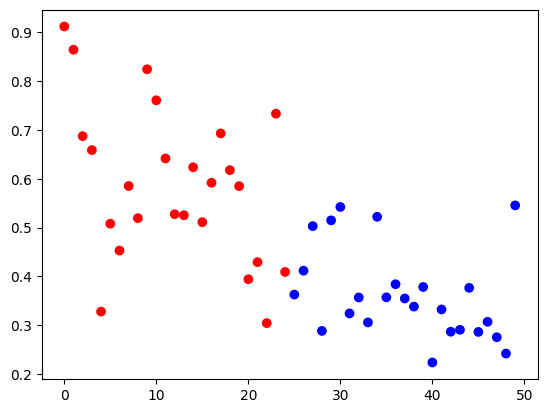

In [144]:
import matplotlib.pyplot as plt

colors = []

for i in range(25):
    colors.append('red')

for j in range(25):
    colors.append('blue')

plt.scatter(range(params_df['alpha'].size), params_df['alpha'], color=colors)
plt.show()

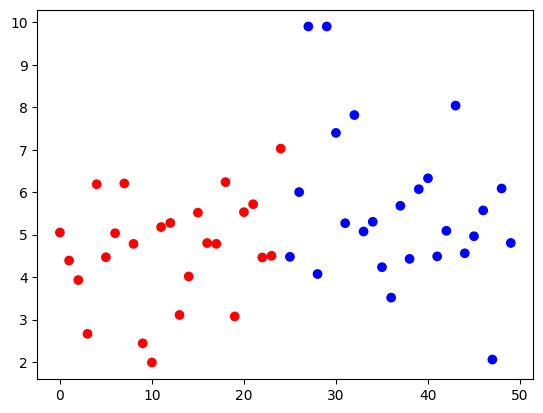

In [145]:
colors = []

for i in range(25):
    colors.append('red')

for j in range(25):
    colors.append('blue')

plt.scatter(range(params_df['beta'].size), params_df['beta'], color=colors)
plt.show()

In [147]:
stats.pearsonr(params_df['alpha'], params_df['beta'])

PearsonRResult(statistic=-0.2471587298077043, pvalue=0.0835531092366362)

In [149]:
stats.pearsonr(params_df['alpha'].iloc[0:25], params_df['alpha'].iloc[25:50])

PearsonRResult(statistic=0.0462564624644245, pvalue=0.8262148773165934)

In [150]:
stats.pearsonr(params_df['beta'].iloc[0:25], params_df['beta'].iloc[25:50])

PearsonRResult(statistic=0.31852857636357024, pvalue=0.1206993371186486)

# Some Try

In [159]:
group_anxious = params_df.iloc[0:25]
group_calm = params_df.iloc[25:50]

In [164]:
print(group_anxious['alpha'].mean())
print(group_calm['alpha'].mean())

0.5874738841443152
0.3641136594134094


In [165]:
print(group_anxious['beta'].mean())
print(group_calm['beta'].mean())

4.655725480207733
5.645647907467197


In [181]:
print(group_anxious['alpha'].std())
print(group_calm['alpha'].std())

0.15894583408826718
0.0937523704156621


In [167]:
print(group_anxious['beta'].std())
print(group_calm['beta'].std())

1.265532536739041
1.8247627143798375


In [183]:
# if p > 0.05 => normal distribution

stats.kstest(group_anxious['alpha'], 'norm', (group_anxious['alpha'].mean(), group_anxious['alpha'].std()))

KstestResult(statistic=0.08750079792850396, pvalue=0.9819204122722219, statistic_location=0.527299876631122, statistic_sign=1)

In [184]:
stats.kstest(group_calm['alpha'], 'norm', (group_calm['alpha'].mean(), group_calm['alpha'].std()))

KstestResult(statistic=0.17731278370735137, pvalue=0.36780704481008364, statistic_location=0.3836866089121128, statistic_sign=1)

In [185]:
stats.kstest(group_anxious['beta'], 'norm', (group_anxious['beta'].mean(), group_anxious['beta'].std()))

KstestResult(statistic=0.1373781900151615, pvalue=0.682595392401693, statistic_location=4.39172869744073, statistic_sign=-1)

In [186]:
stats.kstest(group_calm['beta'], 'norm', (group_calm['beta'].mean(), group_calm['beta'].std()))

KstestResult(statistic=0.16445426789012763, pvalue=0.45992514322686295, statistic_location=6.086938178314062, statistic_sign=1)

# Task (f)

In [195]:
t, p = stats.ttest_ind(group_anxious['alpha'], group_calm['alpha'], equal_var=False)

print("t:", t)
print("P:", p)
print("mean of anxious group has significant difference to that of calm group.")

t: 6.051963984201755
P: 4.4292200917754613e-07
mean of anxious group has significant difference to that of calm group.


In [196]:
t, p = stats.ttest_ind(group_anxious['beta'], group_calm['beta'], equal_var=False)

print("t:", t)
print("P:", p)
print("anxious group have similar mean to calm group.")

t: -2.228892207756577
P: 0.031130808054821983
anxious group have similar mean to calm group.


# Task (g)

In [284]:
def generate_stimuli_g(alpha, beta):
    state = (0.7, 0.3)

    num = 160

    sim_choice = np.zeros(num)
    sim_outcome = np.zeros(num)

    V_A = 0.5
    V_B = 0.5

    for t in range(num):
        if (t + 1) % 40 == 0:
            state = change_state(state)

        p_A = get_p(V_A, V_B, beta)

        choice = 1 if np.random.rand() < p_A else 2

        check = np.random.rand()
        thres = state[0]

        outcome = int(check < thres) if choice == 1 else int(check > thres)

    #     print(f"c: {'A' if choice == 1 else 'B'}, o: {'-' if outcome == 0 else 'aversive'}")

        sim_choice[t] = choice
        sim_outcome[t] = outcome

        V_A = get_V(V_A, alpha, outcome) if choice == 1 else V_A
        V_B = get_V(V_B, alpha, outcome) if choice == 2 else V_B
    
    return sim_choice, sim_outcome

In [285]:
def NLL_g(theta, index, choices, outcomes):
    alpha = theta[0]
    beta = theta[1]
    
    state = (0.7, 0.3)

    V_A = 0.5
    V_B = 0.5

    value = 0.0

    for t in range(160):
        if (t + 1) % 40 == 0:
            state = change_state(state)

    #     print(f't: {t}, c: {inst_choices.iloc[patient_index][t]}, o: {inst_outcomes.iloc[patient_index][t]}')
        
        choice = choices.iloc[index][t]
        
        value += np.log(get_p(V_A, V_B, beta)) if choice == 1 else np.log(get_p(V_B, V_A, beta))

        if choice == 1:
            V_A = get_V(V_A, alpha, outcomes.iloc[index][t])
        elif choice == 2:
            V_B = get_V(V_B, alpha, outcomes.iloc[index][t])
        else:
            raise ValueError(f'Unexpected choice {choice}')

    value = - value

    return value

In [286]:
def get_opt_g(index, choices, outcomes):
    opt_min = optimize.minimize(NLL_g, [0.4, 7], 
                            args=(index, choices, outcomes), 
                            bounds=[(0, 1), (0.1, 9.9)], 
                            method='Nelder-Mead')
    return opt_min

In [287]:
# alpha_set, beta_set = np.random.multivariate_normal([0.5, 5.0], [[0.01, 0], [0, 0.5]], 50).T

# plt.plot(alpha_set, beta_set, '+')

In [288]:
# gen_params = list(zip(alpha_set, beta_set))

# choices_g_dict = {}
# outcomes_g_dict = {}

# for i in range(len(gen_params)):
#     choices, outcomes = generate_stimuli_g(gen_params[i][0], gen_params[i][1])
    
#     choices_g_dict[i] = choices
#     outcomes_g_dict[i] = outcomes
    
# choices_g = pd.DataFrame(choices_g_dict).T
# outcomes_g = pd.DataFrame(outcomes_g_dict).T

In [289]:
# params_g = {
#     "alpha": [],
#     "beta": [],
# }

# for i in range(50):
#     print(f'subject {i}: {tuple(get_opt_g(i, choices_g, outcomes_g).x)}')
    
#     params_g["alpha"].append(get_opt_g(i, choices_g, outcomes_g).x[0])
#     params_g["beta"].append(get_opt_g(i, choices_g, outcomes_g).x[1])

In [290]:
def param_recovery():
    alpha_set, beta_set = np.random.multivariate_normal([0.5, 5.0], [[0.01, 0], [0, 0.5]], 50).T
    
    gen_params = list(zip(alpha_set, beta_set))

    choices_g_dict = {}
    outcomes_g_dict = {}

    for i in range(len(gen_params)):
        choices, outcomes = generate_stimuli_g(gen_params[i][0], gen_params[i][1])

        choices_g_dict[i] = choices
        outcomes_g_dict[i] = outcomes

    choices_g = pd.DataFrame(choices_g_dict).T
    outcomes_g = pd.DataFrame(outcomes_g_dict).T
    
    params_g = {
        "alpha": [],
        "beta": [],
    }

    for i in range(50):
#         print(f'subject {i}: {tuple(get_opt_g(i, choices_g, outcomes_g).x)}')

        params_g["alpha"].append(get_opt_g(i, choices_g, outcomes_g).x[0])
        params_g["beta"].append(get_opt_g(i, choices_g, outcomes_g).x[1])
        
    return pd.DataFrame(params_g)

In [ ]:
for i in range(10):
    res_g = param_recovery()

    print(stats.pearsonr(res_g['alpha'], res_g['beta']))

# Task (h)

In [ ]:
def get_V_h(v_t, alpha, o, A):
    return A * v_t + alpha * (o - v_t)

In [ ]:
def NLL_h(theta, index):
    alpha = theta[0]
    beta = theta[1]
    A = theta[2]
    
    state = (0.7, 0.3)

    V_A = 0.5
    V_B = 0.5

    value = 0.0

    for t in range(160):
        if (t + 1) % 40 == 0:
            state = change_state(state)

    #     print(f't: {t}, c: {inst_choices.iloc[patient_index][t]}, o: {inst_outcomes.iloc[patient_index][t]}')
        
        choice = inst_choices.iloc[index][t]
        
        value += np.log(get_p(V_A, V_B, beta)) if choice == 1 else np.log(get_p(V_B, V_A, beta))

        if choice == 1:
            V_A = get_V_h(V_A, alpha, inst_outcomes.iloc[index][t], A)
        elif choice == 2:
            V_B = get_V_h(V_B, alpha, inst_outcomes.iloc[index][t], A)
        else:
            raise ValueError(f'Unexpected choice {choice}')

    value = - value

    return value

In [ ]:
params_h = {
    "alpha": [],
    "beta": [],
}

for i in range(50):
    opt_min = optimize.minimize(NLL_h, [0.4, 7, 0.5], 
                                args=(i, ), 
                                bounds=[(0, 1), (0.1, 9.9), (0, 1)], 
                                method='Nelder-Mead')
    
    params_h["alpha"].append(opt_min.x[0])
    params_h["beta"].append(opt_min.x[1])
    
df_h = pd.DataFrame(params_h)

df_h